# Convolutional Neural Networks (CNN) with TensorFlow on SageMaker

* [DataCamp Tutorial](https://www.datacamp.com/community/tutorials/cnn-tensorflow-python)
* [DataCamp Keras Tutorial](https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python)
* [TensorFlow Keras Classification](https://www.tensorflow.org/tutorials/keras/classification)
* [TensorFlow Keras API](https://www.tensorflow.org/guide/keras/functional)
* [TensorFlow Keras Save and Load Models](https://www.tensorflow.org/tutorials/keras/save_and_load)
* [Deploy trained Keras/TensorFlow models to SageMaker](https://aws.amazon.com/blogs/machine-learning/deploy-trained-keras-or-tensorflow-models-using-amazon-sagemaker/)
* [Save and Serializes TensorFlow/Keras Models](https://www.tensorflow.org/guide/keras/save_and_serialize)
* [TensorFlow script mode training and serving](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/tensorflow_script_mode_training_and_serving/tensorflow_script_mode_training_and_serving.ipynb)
* [script for training](https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker-python-sdk/tensorflow_script_mode_training_and_serving/mnist-2.py)

In [1]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

## Explore Data

In [2]:
# Download Fashion MNIST dataset
from tensorflow import keras

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print('Training data shape:', train_images.shape, train_labels.shape)
print('Test data shape:', test_images.shape, test_labels.shape)

Training data shape: (60000, 28, 28) (60000,)
Test data shape: (10000, 28, 28) (10000,)


In [4]:
classes = np.unique(train_labels)
num_classes = len(classes)
print('Total number of outputs:', num_classes)
print('Output classes:', classes)

Total number of outputs: 10
Output classes: [0 1 2 3 4 5 6 7 8 9]


In [6]:
def display_image(image, label, cmap=None):
    plt.figure(figsize=(5,5))
    plt.imshow(image, cmap=cmap)
    plt.colorbar()
    plt.grid(False)
    plt.title("Ground truth: {}".format(label))
    plt.show()

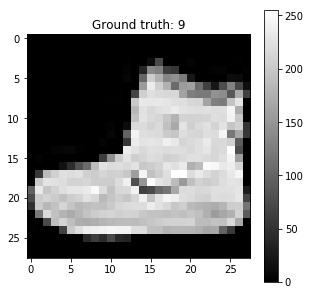

In [7]:
display_image(train_images[0], train_labels[0], cmap="gray")

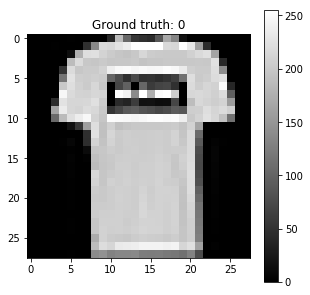

In [8]:
display_image(train_images[1], train_labels[1], cmap="gray")

## Preprocess Images

In [9]:
# Scale the values of the images to a range of 0 to 1 before feeding into CNN
def preprocess_images(images):
    # reshape each image from 28,28 to a 28,28,1
    preprocessed_images = images.reshape(-1, 28,28, 1)
    # convert type to float32
    preprocessed_images = preprocessed_images.astype('float32')
    return preprocessed_images / 255

In [10]:
train_X = preprocess_images(train_images)
test_X = preprocess_images(test_images)

In [11]:
# Convert labels to one hot encoding
def convert_to_one_hot_labels(labels, num_classes=10):
    return keras.utils.to_categorical(labels, num_classes=num_classes)

In [12]:
train_Y = convert_to_one_hot_labels(train_labels, num_classes)
test_Y = convert_to_one_hot_labels(test_labels, num_classes)

In [13]:
# Split dataset
from sklearn.model_selection import train_test_split

In [14]:
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=13)

In [15]:
train_X.shape, valid_X.shape, train_Y.shape, valid_Y.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

## Save and Upload Data

In [16]:
data_dir = 'fashion-data'
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    
np.save(os.path.join(data_dir, 'train_data.npy'), train_X)
np.save(os.path.join(data_dir, 'train_labels.npy'), train_Y)
np.save(os.path.join(data_dir, 'eval_data.npy'), valid_X)
np.save(os.path.join(data_dir, 'eval_labels.npy'), valid_Y)
np.save(os.path.join(data_dir, 'test_data.npy'), test_X)
np.save(os.path.join(data_dir, 'test_labels.npy'), test_Y)

In [17]:
bucket = sagemaker_session.default_bucket()
prefix = 'fashion-data'

In [18]:
training_data_uri = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

## Train Model

In [19]:
from sagemaker.tensorflow import TensorFlow

training_script = 'train.py'
estimator = TensorFlow(entry_point=training_script,
                       role=role,
                       train_instance_count=1,
                       train_instance_type='ml.p2.xlarge',
                       framework_version='2.0.0',
                       py_version='py3',
                       distributions={'parameter_server': {'enabled': True}})

In [20]:
!pygmentize train.py

# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.import tensorflow as tf

import argparse
import os
import numpy as np
import json

from tensorflow import keras
from tensorflow.keras import (
    layers,
    models,
    activations,
    losses,
    optimizers,
)

NUM_CLASSES = 10


def model(x_train, y_train, x_test, y_test):
    """Generate a simple model"""
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),paddi

In [42]:
batch_size = 64
epochs = 20

In [43]:
estimator.fit(training_data_uri)

2020-01-13 04:33:11 Starting - Starting the training job...
2020-01-13 04:33:12 Starting - Launching requested ML instances......
2020-01-13 04:34:35 Starting - Preparing the instances for training......
2020-01-13 04:35:26 Downloading - Downloading input data...
2020-01-13 04:36:02 Training - Training image download completed. Training in progress..2020-01-13 04:36:07,007 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-01-13 04:36:07,016 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-01-13 04:36:07,389 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-01-13 04:36:07,408 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-01-13 04:36:07,422 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-01-13 04:36:07,433 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters":

In [44]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

--------------------------------------------------------------------------!

## Model Evaluation

Here the model's performance is evaluated further by using the test datasets.

In [117]:
from sklearn import metrics

def evaluate_model(true_labels, predicted_labels):
    print(metrics.accuracy_score(true_labels, predicted_labels))

def plot_evaluation(model_train):
    accuracy = model_train.history['accuracy']
    val_accuracy = model_train.history['val_accuracy']
    loss = model_train.history['loss']
    val_loss = model_train.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    

In [127]:
predictions = predictor.predict(test_X[:100])

In [128]:
true_labels = test_Y[:100]
predicted_labels = convert_to_one_hot_labels(np.argmax(predictions['predictions'], axis=1))

evaluate_model(true_labels, predicted_labels)

0.89


## Adding Dropout Layer

In [21]:
from sagemaker.tensorflow import TensorFlow

training_script = 'train-dropout.py'
estimator_dropout = TensorFlow(entry_point=training_script,
                               role=role,
                               train_instance_count=1,
                               train_instance_type='ml.p2.xlarge',
                               framework_version='2.0.0',
                               py_version='py3',
                               distributions={'parameter_server': {'enabled': True}})

In [22]:
!pygmentize train-dropout.py

# Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.import tensorflow as tf

import argparse
import os
import numpy as np
import json

from tensorflow import keras
from tensorflow.keras import (
    layers,
    models,
    activations,
    losses,
    optimizers,
)

NUM_CLASSES = 10


def model(x_train, y_train, x_test, y_test):
    """Generate a simple model"""
    model = keras.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),paddi

In [23]:
batch_size = 64
epochs = 20

In [24]:
estimator_dropout.fit(training_data_uri)

2020-01-13 05:47:43 Starting - Starting the training job...
2020-01-13 05:47:44 Starting - Launching requested ML instances...
2020-01-13 05:48:40 Starting - Preparing the instances for training.........
2020-01-13 05:50:04 Downloading - Downloading input data...
2020-01-13 05:50:39 Training - Downloading the training image...
2020-01-13 05:51:06 Training - Training image download completed. Training in progress..2020-01-13 05:51:10,301 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-01-13 05:51:10,786 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sagemaker_parameter_server_enabled": true
    },
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "model_dir": "s3://

In [27]:
print(estimator_dropout.train_instance_type)

ml.p2.xlarge


In [28]:
predictor = estimator_dropout.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

--------------------------------------------------!

In [29]:
from sklearn import metrics

def evaluate_model(true_labels, predicted_labels):
    print(metrics.accuracy_score(true_labels, predicted_labels))

def plot_evaluation(model_train):
    accuracy = model_train.history['accuracy']
    val_accuracy = model_train.history['val_accuracy']
    loss = model_train.history['loss']
    val_loss = model_train.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    

In [49]:
from sklearn.utils import shuffle

random_state = 0
n_samples = 300

# The endpoint can't handle too many predictions because of the instance size
test_X_subset, true_labels = shuffle(test_X, test_Y, n_samples=n_samples, random_state=random_state)

In [50]:
print(test_X_subset.shape)
print(true_labels.shape)

(300, 28, 28, 1)
(300, 10)


In [51]:
predictions = predictor.predict(test_X_subset)

In [52]:
predicted_labels = convert_to_one_hot_labels(np.argmax(predictions['predictions'], axis=1))
evaluate_model(true_labels, predicted_labels)

0.8733333333333333


In [53]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(true_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.69      0.78      0.73        23
     Class 1       1.00      0.96      0.98        27
     Class 2       0.75      0.70      0.72        30
     Class 3       0.95      0.95      0.95        37
     Class 4       0.72      0.85      0.78        27
     Class 5       0.97      0.94      0.95        31
     Class 6       0.65      0.57      0.61        30
     Class 7       0.96      1.00      0.98        27
     Class 8       1.00      0.97      0.99        37
     Class 9       0.97      0.97      0.97        31

   micro avg       0.87      0.87      0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300
 samples avg       0.87      0.87      0.87       300

